# Unsupervised action segmentation of egocentric videos

#### Init.

In [1]:
import os
import numpy as np
import pandas as pd
import os
import warnings
import time
warnings.filterwarnings("ignore")
%precision 2

# Import our own algorithms
from src.dataset import VideoFrameDataset
from src.pipeline import Pipeline
from src.metrics import Annotation
from src.const import DEFAULT_CONFIG

#### Segmentation of a sample video

In [2]:
video_path = './data/sample_video.mp4'
ground_truth_path = './data/sample_video_ground_truth.csv'
feature_vectors_path = './data/sample_video_features.npy'
num_actions = 3

Using cache found in /Users/samperochon/.cache/torch/hub/pytorch_vision_v0.10.0


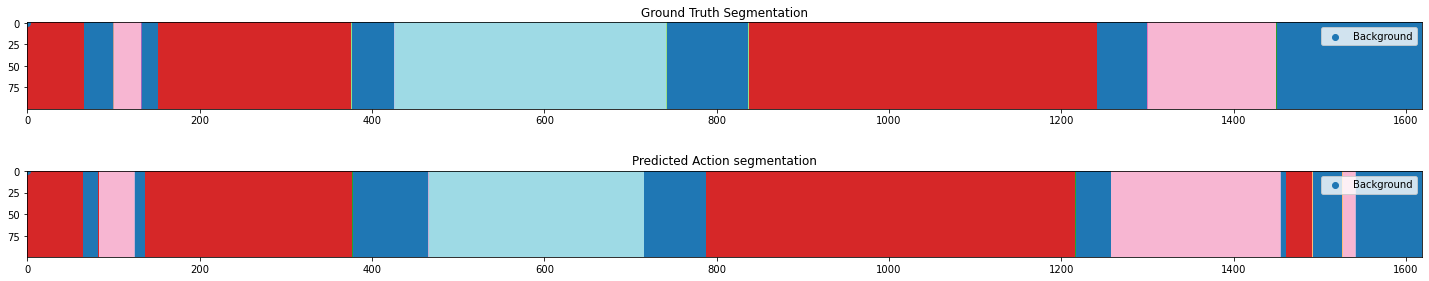

Frame-wise accuracy: 0.83
Frame-wise F1-score (macro averaging): 0.81
Jaccard index: 0.70
Edit score (Levenstein metric): 75.00
Segment-wise F1@.10: 85.71
Segment-wise F1@.25: 85.71
Segment-wise F1@.50: 85.71
--- Runtime: 6.280426025390625 seconds ---

Done! You can find the output png of the segmentation in ./outputs/output.png, the performance in ./outputs/performances.csv, and segmentation in ./outputs/prediction.csv


In [3]:
start_time = time.time()

# Create the video dataset
dataset = VideoFrameDataset(filename=video_path, config=DEFAULT_CONFIG)

# Create the ground truth and metrics computation object
annotation = Annotation()
if ground_truth_path is not None:
    df = pd.read_csv(ground_truth_path)
    annotation.populate_ground_truth(df, dataset.n_frames)

# Create the pipeline object
pipeline = Pipeline(dataset=dataset, annotation=annotation, config=DEFAULT_CONFIG, verbosity=0)

# Compute frame embedding
pipeline.compute_embedding(path=feature_vectors_path)

# Do thte background extraction
pipeline.outlier_methods = ['custom', 'silhouette_score']
pipeline.remove_outliers_method()

# Calibration of the lambda parameter 
regularization_lambda = int(10*3000/dataset.n_frames)

# Detect ruptures
pipeline.detect_ruptures(penalty=regularization_lambda, ruptures_on = 'embedding_ts', remove_outliers=True, verbose=False)

if ground_truth_path is not None:
    # Take as number of cluster the number of different actions in the ground truth
    num_clusters = len(np.unique(annotation.gt_label)) - 1

else:
    num_clusters = num_actions

# Cluster non-background segments
pipeline.cluster_frames(n_clusters=num_clusters, method='kmeans')

# Compute metrics and plot results
pipeline.annotation.compute_metrics()
pipeline.annotation.plot()
if ground_truth_path is not None:
    pipeline.annotation.compute_metrics()

    # Create outputs
    pipeline.create_outputs()

    print("Frame-wise accuracy: {:.2f}".format(pipeline.annotation.accuracy))
    print("Frame-wise F1-score (macro averaging): {:.2f}".format(pipeline.annotation.f1_macro))
    print("Jaccard index: {:.2f}".format(pipeline.annotation.iou))
    print("Edit score (Levenstein metric): {:.2f}".format(pipeline.annotation.edit))
    print("Segment-wise F1@.10: {:.2f}".format(pipeline.annotation.f1_10))
    print("Segment-wise F1@.25: {:.2f}".format(pipeline.annotation.f1_25))
    print("Segment-wise F1@.50: {:.2f}".format(pipeline.annotation.f1_50))

print("--- Runtime: %s seconds ---" % (time.time() - start_time))
print("\nDone! You can find the output png of the segmentation in ./outputs/output.png, the performance in ./outputs/performances.csv, and segmentation in ./outputs/prediction.csv")

#### Init.

In [3]:
import os
import numpy as np
import pandas as pd
import os
import warnings
import time

# Import our own algorithms
from src.dataset import VideoFrameDataset
from src.pipeline import Pipeline
from src.metrics import Annotation
from src.const import DEFAULT_CONFIG

#### Segmentation of a sample video
video_path = './data/sample_video.mp4'
ground_truth_path = './data/sample_video_ground_truth.csv'
feature_vectors_path = './data/sample_video_features.npy'

start_time = time.time()

# Create the video dataset
dataset = VideoFrameDataset(filename=video_path, config=DEFAULT_CONFIG)

# Create the ground truth and metrics computation object
annotation = Annotation()
if ground_truth_path is not None:
    df = pd.read_csv(ground_truth_path)
    annotation.populate_ground_truth(df, dataset.n_frames)

# Create the pipeline object
pipeline = Pipeline(dataset=dataset, annotation=annotation, config=DEFAULT_CONFIG, verbosity=0)

# Compute frame embedding
pipeline.compute_embedding(path=feature_vectors_path)

# Do thte background extraction
pipeline.outlier_methods = ['custom', 'silhouette_score']
pipeline.remove_outliers_method()

# Calibration of the lambda parameter 
regularization_lambda = int(10*3000/dataset.n_frames)

# Detect ruptures
pipeline.detect_ruptures(penalty=regularization_lambda, ruptures_on = 'embedding_ts', remove_outliers=True, verbose=False)

# Take as number of cluster the number of different actions in the ground truth
num_clusters = len(np.unique(annotation.gt_label)) - 1

# Cluster non-background segments
pipeline.cluster_frames(n_clusters=num_clusters, method='kmeans')

# Compute metrics and plot results
pipeline.annotation.compute_metrics()
pipeline.annotation.plot()
pipeline.annotation.compute_metrics()

# Create outputs
pipeline.create_outputs()

print("Frame-wise accuracy: {:.2f}".format(pipeline.annotation.accuracy))
print("Frame-wise F1-score (macro averaging): {:.2f}".format(pipeline.annotation.f1_macro))
print("Jaccard index: {:.2f}".format(pipeline.annotation.iou))
print("Edit score (Levenstein metric): {:.2f}".format(pipeline.annotation.edit))
print("Segment-wise F1@.10: {:.2f}".format(pipeline.annotation.f1_10))
print("Segment-wise F1@.25: {:.2f}".format(pipeline.annotation.f1_25))
print("Segment-wise F1@.50: {:.2f}".format(pipeline.annotation.f1_50))

print("--- Runtime: %s seconds ---" % (time.time() - start_time))
print("\nDone! You can find the output png of the segmentation in ./outputs/output.png, the performance in ./outputs/performances.csv, and segmentation in ./outputs/prediction.csv")